In [1]:
# Import Libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from collections import Counter
from string import punctuation

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder 
from sklearn.metrics import precision_score, recall_score , f1_score, accuracy_score,confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from gensim.models import Word2Vec

import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential 
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Dense , Embedding , Bidirectional , LSTM

lemma = WordNetLemmatizer()
lb = LabelEncoder()

# Loading Dataset

In [2]:
df = pd.read_csv('C:/Users/RAHUL/Downloads/projects Datasets/Restaurant reviews.csv')

In [3]:
df.head()

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures,7514
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5,"1 Review , 2 Followers",5/25/2019 15:54,0,2447.0
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5,"3 Reviews , 2 Followers",5/25/2019 14:20,0,NaN
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5,"2 Reviews , 3 Followers",5/24/2019 22:54,0,NaN
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5,"1 Review , 1 Follower",5/24/2019 22:11,0,NaN
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5,"3 Reviews , 2 Followers",5/24/2019 21:37,0,NaN


In [4]:
df.columns

Index(['Restaurant', 'Reviewer', 'Review', 'Rating', 'Metadata', 'Time',
       'Pictures', '7514'],
      dtype='object')

In [5]:
df.drop(['Restaurant' , 'Reviewer' , 'Metadata' , 'Time', 'Pictures' , '7514'],axis='columns',inplace=True)

In [6]:
df.isnull().sum()

Review    45
Rating    38
dtype: int64

In [7]:
df = df.dropna()

In [8]:
np.unique(df['Rating'])

array(['1', '1.5', '2', '2.5', '3', '3.5', '4', '4.5', '5', 'Like'],
      dtype=object)

In [9]:
df['Rating'] = df['Rating'].replace(['Like'], '5')

In [10]:
df['Rating'] = df['Rating'].astype(float)

In [11]:
def convert_label(df):
    if df['Rating'] <= 3.0 :
        rate = 'Negative'
    else :
        rate = 'Positive'
        
    return rate    

In [12]:
df['Rating'] = df.apply(convert_label , axis = 1)

In [13]:
df.head()

,Review,Rating
0,"The ambience was good, food was quite good . h...",Positive
1,Ambience is too good for a pleasant evening. S...,Positive
2,A must try.. great food great ambience. Thnx f...,Positive
3,Soumen das and Arun was a great guy. Only beca...,Positive
4,Food is good.we ordered Kodi drumsticks and ba...,Positive


### EDA

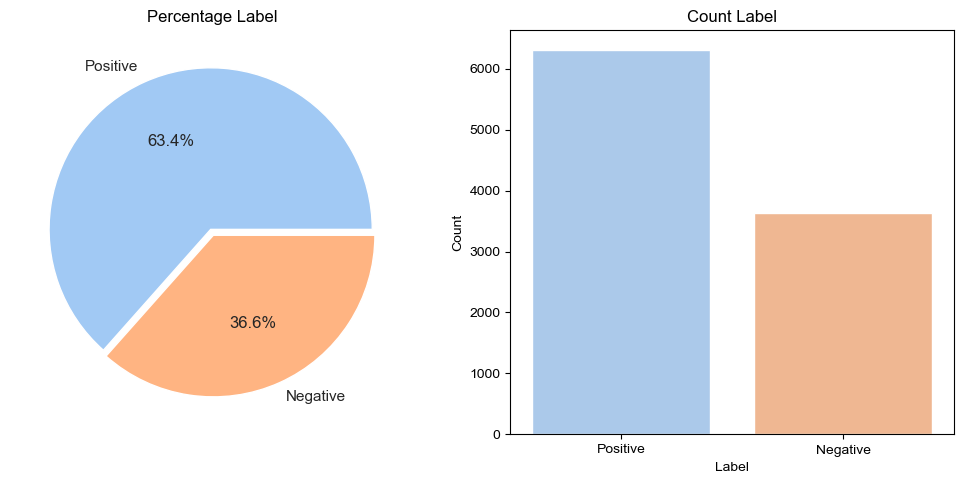

In [14]:
label_count = df['Rating'].value_counts()
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

sns.set_theme(style='darkgrid', palette='pastel')
color = sns.color_palette(palette='pastel')
explode = [0.02]*len(label_count)

axes[0].pie(label_count.values, labels=label_count.index, autopct='%1.1f%%', colors=color, explode=explode)
axes[0].set_title('Percentage Label')

sns.countplot(df['Rating'] , ax=axes[1])
axes[1].set_title('Count Label')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [15]:
def Most_Words_used(text , num_of_words) :
    all_text = ''.join(df[text].values)
    
    words = all_text.split()
    
    punc = list(punctuation)
    words = [w for w in words if w not in punc]
    
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if not word in stop_words ]
    word_counts = Counter(words)
    top_words = word_counts.most_common(num_of_words)
    
    return top_words

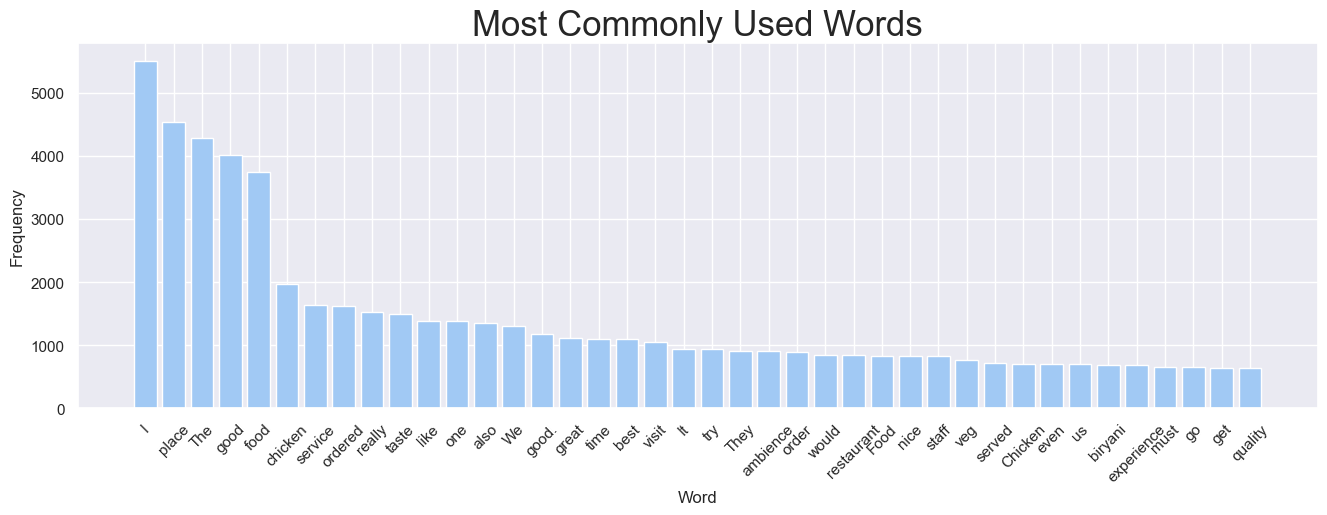

In [16]:
top_words = Most_Words_used('Review' , 40)

xaxis = [word[0] for word in top_words]
yaxis = [word[1] for word in top_words]

plt.figure(figsize=(16,5))
plt.bar(xaxis , yaxis)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Most Commonly Used Words', fontsize=25)
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.15)
plt.show()

## Data Preprocessing

In [17]:
def DataPrep(text):
    tokens = nltk.word_tokenize(text)
    
    #remove puncs
    punc = list(punctuation)
    
    words = [w for w in tokens if w not in punc]
    
    # remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if not word in stop_words ]
    
    # lemmatization
    words = [lemma.lemmatize(w) for w in words]
    text = ' '.join(words)
    return text


In [18]:
df['cleaned_reviews'] = df['Review'].apply(DataPrep)

In [19]:
print(f'There are around {int(df["cleaned_reviews"].duplicated().sum())} duplicated tweets, we will remove them.')

There are around 684 duplicated tweets, we will remove them.


In [20]:
df.drop_duplicates("cleaned_reviews", inplace=True)

In [21]:
df.head()

,Review,Rating,cleaned_reviews
0,"The ambience was good, food was quite good . h...",Positive,The ambience good food quite good Saturday lun...
1,Ambience is too good for a pleasant evening. S...,Positive,Ambience good pleasant evening Service prompt ...
2,A must try.. great food great ambience. Thnx f...,Positive,A must try .. great food great ambience Thnx s...
3,Soumen das and Arun was a great guy. Only beca...,Positive,Soumen da Arun great guy Only behavior sincere...
4,Food is good.we ordered Kodi drumsticks and ba...,Positive,Food good.we ordered Kodi drumstick basket mut...


# Split the data

In [22]:
x_train , x_test ,  y_train ,  y_test = train_test_split(df['cleaned_reviews'] , df['Rating'] , train_size = 0.80 , random_state=42)

In [23]:
len(x_train) , len(x_test)

(7416, 1855)

## Feature Extraction

In [24]:
vectorizer = TfidfVectorizer()
vectorizer.fit(x_train)
print("No. of feature words: ", len(vectorizer.vocabulary_))

No. of feature words:  12779


In [25]:
x_train = vectorizer.transform(x_train).toarray()
x_test = vectorizer.transform(x_test).toarray()

## Encoding 

In [26]:
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)

## Logistic Regression

In [27]:
lr = LogisticRegression(random_state=42)
lr.fit(x_train , y_train)

LogisticRegression(random_state=42)

In [28]:
train_acc1 = lr.score(x_train , y_train)

In [29]:
lr_pred = lr.predict(x_test)

test_acc1 = accuracy_score(y_test , lr_pred)

test_precision1 = precision_score(y_test , lr_pred , average='weighted')
test_recall1 = recall_score(y_test , lr_pred , average='weighted')
test_f1score1 = f1_score(y_test , lr_pred , average='weighted')

In [30]:
print(f"The training accuracy for logistic regression : {(train_acc1*100):0.2f}%\n")
print(f"The testing accuracy for logistic regression : {(test_acc1*100):0.2f}%\n")
print(f"The precision for logistic regression : {test_precision1:0.2f}\n")
print(f"The recall for logistic regression : {test_recall1:0.2f}\n")
print(f"The f1 score for logistic regression : {test_f1score1:0.2f}\n")

The training accuracy for logistic regression : 91.86%

The testing accuracy for logistic regression : 88.09%

The precision for logistic regression : 0.88

The recall for logistic regression : 0.88

The f1 score for logistic regression : 0.88



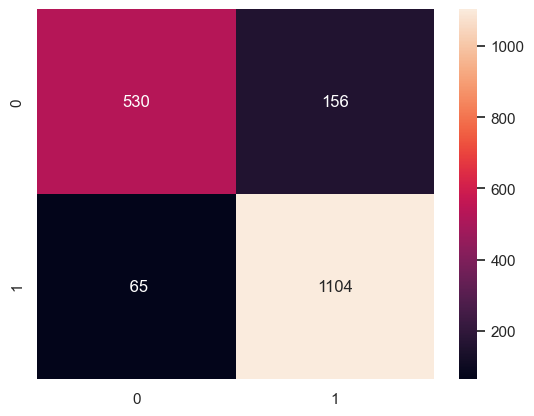

In [31]:
lr_cm = confusion_matrix(y_test , lr_pred)
sns.heatmap(lr_cm, annot=True,fmt='3g')
plt.show()

# Random Forest Classifier

In [32]:
rf = RandomForestClassifier(random_state=42)
rf.fit(x_train , y_train)

RandomForestClassifier(random_state=42)

In [36]:
train_acc2 = rf.score(x_train , y_train)

In [35]:
rf_pred = rf.predict(x_test)

test_acc2 = accuracy_score(y_test , lr_pred) 

test_precision2 = precision_score(y_test , rf_pred , average='weighted')
test_recall2 = recall_score(y_test , rf_pred , average='weighted')
test_f1score2 = f1_score(y_test , rf_pred , average='weighted')